# Googlecolab mount

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/강우예측AI

/content/drive/My Drive/강우예측AI


In [3]:
ls

Dacon_baseline_4.csv  sample_submission.csv  test.zip  train.zip


## Google Colab에서 zip 해제

파일 위치:

구글 드라이브 > 내 드라이브 > 강우예측 AI

In [4]:
import zipfile

In [5]:
cd /content

/content


In [6]:
pwd

'/content'

In [7]:
path = "/content/drive/My Drive/강우예측AI" # 절대경로로 압축해제할 파일위치 지정

In [8]:
# 압축해제된 파일은 content 즉, colab 상에 위치하므로 세션 초기화되면 삭제됨
# 압축해제 위치를 구글드라이브 강우예측 AI 폴더로 지정 가능

# 현재 디렉터리 ./ 확인!
zip_file = zipfile.ZipFile(path + "/train.zip")
zip_file.extractall("/content")          # 압축해제하여 현재 디렉토리에 저장. 내부의 train 폴더 자동 생성
print("========== Training data 압축해제 완료 ==========")

zip_file2 = zipfile.ZipFile(path + "/test.zip")
zip_file2.extractall("/content/test/")  # 압축해제하여 현재 디렉토리 아래 test 폴더에 저장
print("========== Test data 압축해제 완료 ==========")

### Training data 전처리

In [9]:
import glob

# 정렬로 읽어들임
train_files = sorted(glob.glob("/content/train/*.npy"))
print(len(train_files))

62735


In [10]:
# 정렬되었는지 확인
for i in range(10):
    print(train_files[i])

/content/train/train_00000.npy
/content/train/train_00001.npy
/content/train/train_00002.npy
/content/train/train_00003.npy
/content/train/train_00004.npy
/content/train/train_00005.npy
/content/train/train_00006.npy
/content/train/train_00007.npy
/content/train/train_00008.npy
/content/train/train_00009.npy


In [13]:
# np.array로 변환
import numpy as np

train_files = np.array(train_files)
print(train_files.shape)

(62735,)


In [15]:
# 내 방식으로 데이터 추출
train_x = []
train_y = []

for f in train_files:  # f로 각각의 데이터 읽어들임
    
    data = np.load(f)  # np.load로 f를 읽음
    label = data[:, :, -1].reshape(120, 120, 1)  # 5장 중 마지막장은 라벨로 따로 처리
    remove_minus = np.where(label < 0, 0, label) # 라벨 이미지의 음수 부분을 0으로 처리
    feature = data[:, :, :4] # 4장의 이미지 input
        
    train_x.append(feature)
    train_y.append(remove_minus)
    

In [16]:
# np.array로 변환
train_x = np.array(train_x)
train_y = np.array(train_y)

# shape 확인
print(train_x.shape)
print(train_y.shape)

(62735, 120, 120, 4)
(62735, 120, 120, 1)


### Test data 전처리

In [17]:
# 정렬로 읽어들임
test_files = sorted(glob.glob("/content/test/*.npy"))
print(len(test_files))

2674


In [18]:
test_files[2] # 개별 데이터는 .npy 확장자가 안풀린 상태??

for i in range(10):
    print(test_files[i])

/content/test/test_00000.npy
/content/test/test_00001.npy
/content/test/test_00002.npy
/content/test/test_00003.npy
/content/test/test_00004.npy
/content/test/test_00005.npy
/content/test/test_00006.npy
/content/test/test_00007.npy
/content/test/test_00008.npy
/content/test/test_00009.npy


In [19]:
# 내 방식으로 데이터 추출
test_x = []
test_y = []

for f in test_files:
    
    data = np.load(f)
    label = data[:, :, -1].reshape(120, 120, 1)
    remove_minus = np.where(label < 0, 0, label)
    feature = data[:, :, :4]
        
    test_x.append(feature) # 4장의 시계열 이미지
    test_y.append(remove_minus) # 음수는 0으로 처리된 5번째 이미지

In [20]:
# np.array로 변환
test_x = np.array(test_x)
test_y = np.array(test_y)

# shape 확인
print(test_x.shape)
print(test_y.shape)

(2674, 120, 120, 4)
(2674, 120, 120, 1)


## Library import

In [21]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, Input
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

from keras.utils import plot_model


## 시각화

In [22]:
# 시각화를 위한 컬러맵 속성 정의
color_map = plt.cm.get_cmap("RdBu")
color_map = color_map.reversed()

# train_files의 2번째 샘플을 예시로 시각화
image_sample = train_x[2]
print(image_sample.shape)

image_target = train_y[2]
print(image_target.shape)

(120, 120, 4)
(120, 120, 1)


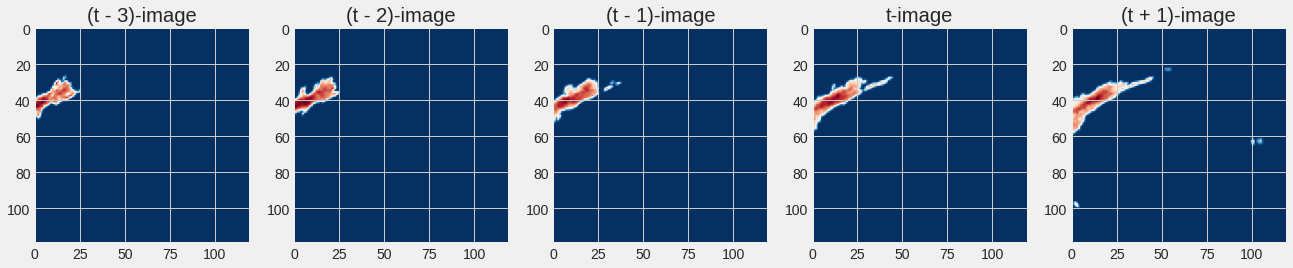

In [23]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 20))

for i in range(4):
    
    if i == 3:
        plt.subplot(1, 5, i + 1)
        plt.title("t-image")
        plt.imshow(image_sample[:, :, i], cmap = color_map)
        
    else:
        plt.subplot(1, 5, i + 1)
        plt.title("(t - {})-image".format(4 - i - 1))
        plt.imshow(image_sample[:, :, i], cmap = color_map) # 4개의 기상관측 이미지(t-3, t-2, t-1, t)를 보여주고, (2차원 행렬)
    
plt.subplot(1, 5, 5)
plt.title("(t + 1)-image")
# reshape로 3차원 -> 2차원 변환
plt.imshow(image_target.reshape(120, 120), cmap = color_map)  # 1개의 그 다음 기상관측 이미지(t+1)를 추측해야 함
plt.show()

## BASELINE Modeling

In [27]:
def build_model():
    
    # input layer
    input_layer = Input((120, 120, 4))
    
    # conv 1
    conv_1 = Conv2D(64, (5, 5), activation = 'relu', padding = 'same')(input_layer)
    batch_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPooling2D((2, 2))(batch_1)
    
    # conv2
    conv_2 = Conv2D(64, (5, 5), activation = 'relu', padding = 'same')(pool_1)
    batch_2 = BatchNormalization()(conv_2)
    pool_2 = MaxPooling2D((2, 2))(batch_2)
    
    # conv3
    conv_3 = Conv2D(256, (4, 4), activation = 'relu', padding = 'same')(pool_2)

    # deconv2
    deconv_2 = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(conv_3)
    uconv_2 = concatenate([deconv_2, conv_2])
    uconv_2 = Conv2D(64, (4, 4), activation="relu", padding="same")(uconv_2)
    uconv_2 = BatchNormalization()(uconv_2)
 
    # deconv1
    deconv_1 = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same")(uconv_2)
    uconv_1 = concatenate([deconv_1, conv_1])
    uconv_1 = Conv2D(32, (4, 4), activation="relu", padding="same")(uconv_1)
    uconv_1 = BatchNormalization()(uconv_1)
    
    # output layer
    output_layer = Conv2D(1, (1, 1), padding="same", activation='relu')(uconv_1)
    
    # model generation
    model = Model(input_layer, output_layer)
    return model

model = build_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 4) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 120, 120, 64) 6464        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 120, 120, 64) 256         conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 60, 60, 64)   0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

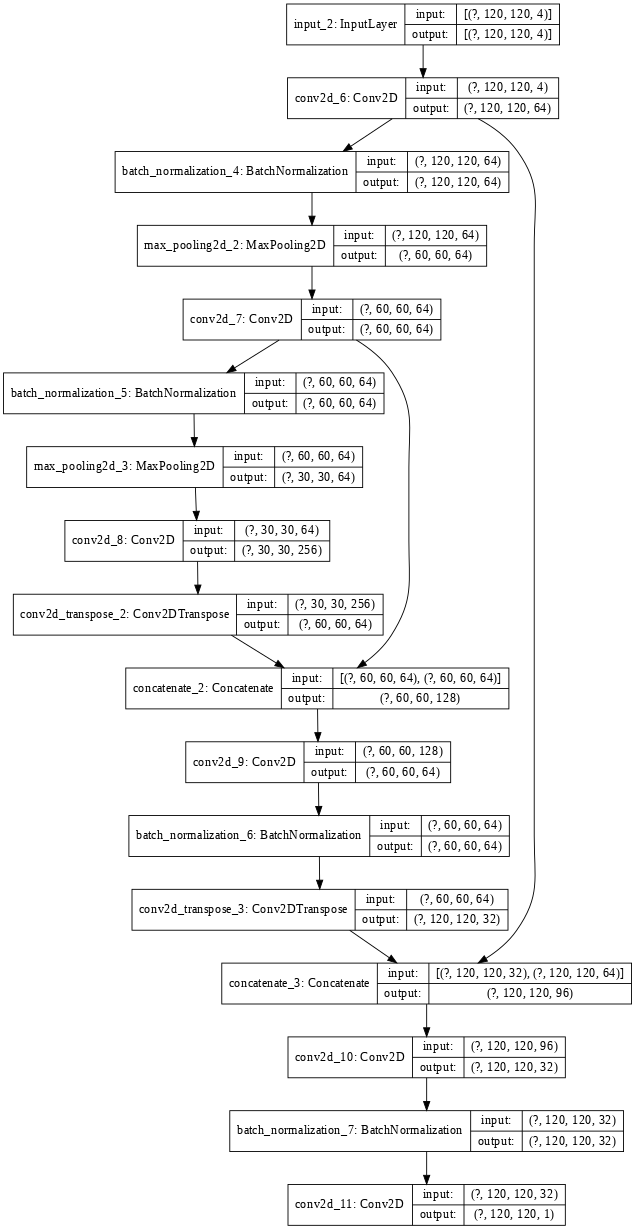

In [28]:
plot_model(model, show_shapes = True, dpi = 64)

In [ ]:
# 학습 방식 결정
model.compile(loss = 'mae',
             optimizer = 'adam',
             metrics = ['mse'])

In [ ]:
# 이 부분에서 콜백 함수에 넣을 콜백리스트 정의할 것!
import keras

callbacks_list = [
    # 조기종료 콜백함수 : val loss 감시, 10에폭까지 기다림
    #keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
    
    # 모델 체크포인트 콜백함수 : 모델을 h5로 저장, 최적 모델만을 저장
    keras.callbacks.ModelCheckpoint(filepath = "Best_Model.h5", monitor = 'val_loss', save_best_only = True),
    
    # 학습률 감소 콜백함수 : val loss 감시, 검증 손실 향상안될때 10분의 1감소시킴
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3)
]

print(callbacks_list)

[<tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7ffb3036ec18>, <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7ffb3036ec88>]


In [ ]:
%%time
# hist객체에 fit history 저장
hist = model.fit(train_x, train_y,
                 epochs = 15,
                 batch_size = 256,
                 callbacks = callbacks_list,
                 validation_split = 0.1,
                 verbose = 1)

Epoch 1/15
221/221 [==============================] - 168s 761ms/step - loss: 9.2971 - mse: 726.4376 - val_loss: 5.2347 - val_mse: 322.7464
Epoch 2/15
221/221 [==============================] - 170s 771ms/step - loss: 4.8439 - mse: 235.8312 - val_loss: 2.7337 - val_mse: 124.8465
Epoch 3/15
221/221 [==============================] - 171s 775ms/step - loss: 3.3369 - mse: 138.4138 - val_loss: 2.7176 - val_mse: 121.7700
Epoch 4/15
221/221 [==============================] - 171s 776ms/step - loss: 3.2280 - mse: 134.0713 - val_loss: 2.5156 - val_mse: 109.1299
Epoch 5/15
221/221 [==============================] - 172s 778ms/step - loss: 3.1898 - mse: 131.6698 - val_loss: 2.4957 - val_mse: 109.9177
Epoch 6/15
221/221 [==============================] - 172s 777ms/step - loss: 3.1567 - mse: 130.1419 - val_loss: 2.5532 - val_mse: 111.1722
Epoch 7/15
221/221 [==============================] - 172s 777ms/step - loss: 3.1261 - mse: 128.5586 - val_loss: 2.4974 - val_mse: 108.9133
Epoch 8/15
221/221 [

In [ ]:
for key in hist.history:
    print(key)

loss
mse
val_loss
val_mse
lr


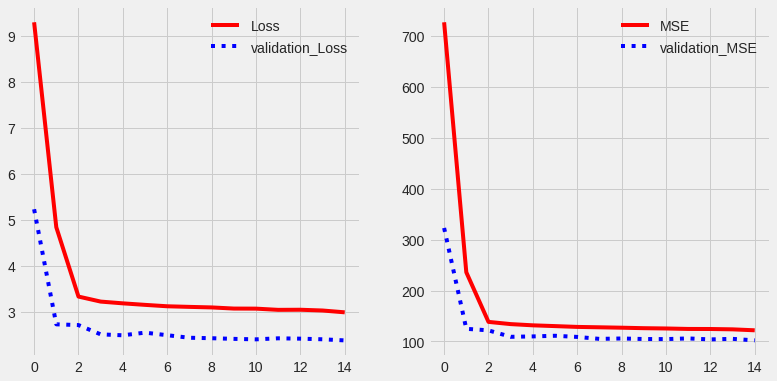

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
mse = hist.history['mse']
val_mse = hist.history['val_mse']
lr = hist.history['lr']

plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss, 'r-', label = 'Loss')
plt.plot(val_loss, "b:", label = 'validation_Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mse, 'r-', label = 'MSE')
plt.plot(val_mse, "b:", label = 'validation_MSE')
plt.legend()

plt.show()

# TEST

In [ ]:
test_files = sorted(glob.glob("/content/test/*.npy"))
print(len(test_files))

2674


In [ ]:
for i in range(10):
    print(test_files[i])

/content/test/test_00000.npy
/content/test/test_00001.npy
/content/test/test_00002.npy
/content/test/test_00003.npy
/content/test/test_00004.npy
/content/test/test_00005.npy
/content/test/test_00006.npy
/content/test/test_00007.npy
/content/test/test_00008.npy
/content/test/test_00009.npy


In [ ]:
test_files = np.array(test_files)
print(test_files.shape)

(2674,)


In [ ]:
test_files[2] # 개별 데이터는 .npy 확장자가 안풀린 상태??

'/content/test/test_00002.npy'

In [ ]:
# 내 방식으로 데이터 추출
test_x = []
test_y = []

for f in test_files:
    
    data = np.load(f)
    label = data[:, :, -1].reshape(120, 120, 1)
    remove_minus = np.where(label < 0, 0, label)
    feature = data[:, :, :4]
        
    test_x.append(feature)
    test_y.append(remove_minus)

In [ ]:
test_x = np.array(test_x)
test_y = np.array(test_y)

print(test_x.shape)
print(test_y.shape)

(2674, 120, 120, 4)
(2674, 120, 120, 1)


In [ ]:
predict = model.predict(test_x)
print(predict.shape)

(2674, 120, 120, 1)


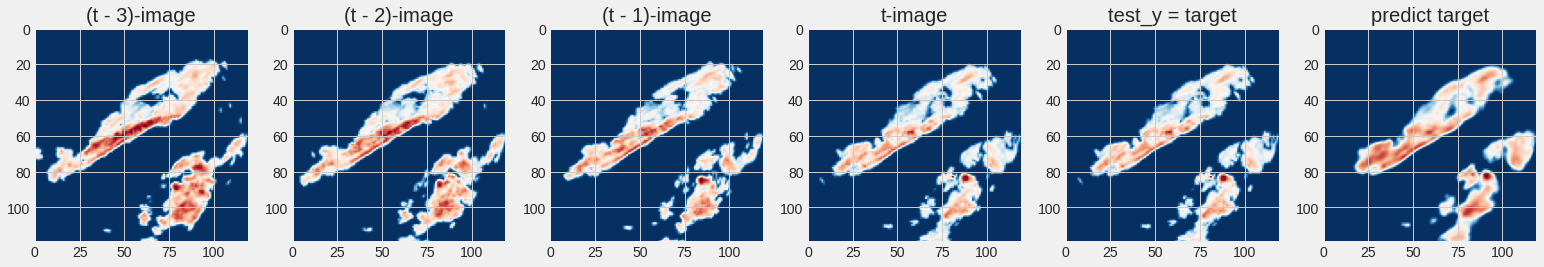

In [ ]:
# 시각화를 위한 컬러맵 속성 정의
color_map = plt.cm.get_cmap("RdBu")
color_map = color_map.reversed()

plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 20))

for j in range(10):  # 10개의 test 데이터에 대한 시각화 확인 작업
    
    image_sample = test_x[j]
    image_target = test_y[j]
    #predicted_target = predict[j]
    
    # 4개의 test_x 데이터를 보여주고
    for i in range(4):
        
        if i == 3:
            plt.subplot(1, 6, i + 1)
            plt.title("t-image")
            plt.imshow(image_sample[:, :, i], cmap = color_map)
        
        else:
            plt.subplot(1, 6, i + 1)
            plt.title("(t - {})-image".format(4 - i - 1))
            plt.imshow(image_sample[:, :, i], cmap = color_map) # 4개의 기상관측 이미지(t-3, t-2, t-1, t)를 보여주고, (2차원 행렬)


    # 1개의 test_y(=target) 데이터 시각화하고
    plt.subplot(1, 6, 5)
    plt.title("test_y = target")
    plt.imshow(image_target.reshape((120, 120)), cmap = color_map)  # 1개의 그 다음 기상관측 이미지(t+1)를 추측해야 함
    
    
    # 1개의 predict(예측) 데이터 시각화한다.
    plt.subplot(1, 6, 6)
    plt.title("predict target")
    plt.imshow(predict[j].reshape((120, 120)), cmap = color_map)
    
    
plt.show()

In [ ]:
# submission.csv 파일을 읽어온다
submission = pd.read_csv("/content/drive/My Drive/강우예측AI/sample_submission.csv")


In [ ]:
# predict결과를 적절히 reshape하여 submission.csv에 저장
submission.iloc[:, 1:] = predict.reshape(-1, 14400).astype(int)
submission.to_csv(path + "/Dacon_baseline_4.csv", index = False)

In [ ]:
ls

Best_Model.h5  drive/  model.png  sample_data/  test/  train/
